Epoch 1/10
13/13 [==============================] - 2s 149ms/step - loss: 0.0121
Epoch 2/10
13/13 [==============================] - 2s 151ms/step - loss: 0.0024
Epoch 3/10
13/13 [==============================] - 2s 146ms/step - loss: 0.0012
Epoch 4/10
13/13 [==============================] - 2s 142ms/step - loss: 5.9451e-04
Epoch 5/10
13/13 [==============================] - 2s 147ms/step - loss: 3.4369e-04
Epoch 6/10
13/13 [==============================] - 2s 145ms/step - loss: 3.2600e-04
Epoch 7/10
13/13 [==============================] - 2s 157ms/step - loss: 3.1259e-04
Epoch 8/10
13/13 [==============================] - 2s 152ms/step - loss: 2.9841e-04
Epoch 9/10
13/13 [==============================] - 2s 150ms/step - loss: 2.9543e-04
Epoch 10/10
13/13 [==============================] - 2s 152ms/step - loss: 2.8330e-04

_____SUMMARY_____

Linear Regression:

Coefficient:  0.06180542741777561

Intercept:  25.04848222239947

R square:  0.6834534824528073


Recurrent Neural Networ

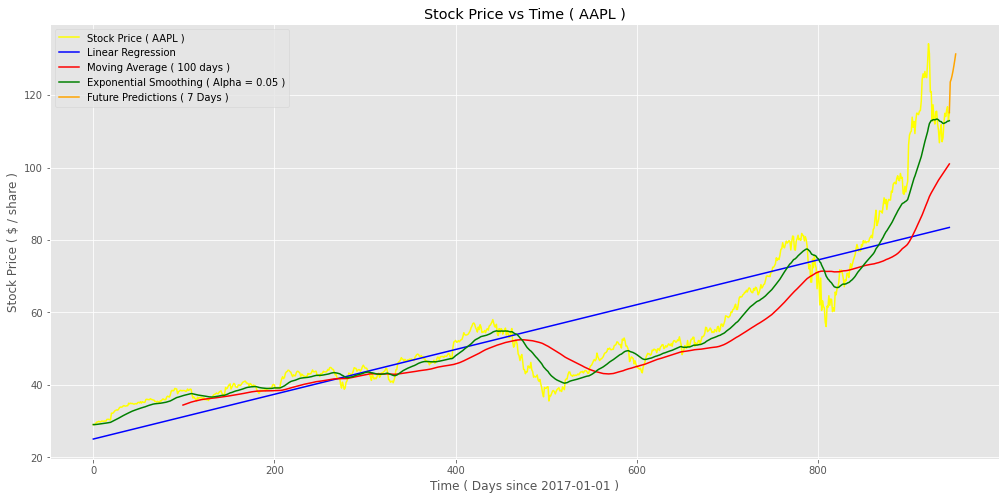

In [4]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import pandas as pd
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math

## Select the starting date here (At least 1 year ago)
start = dt.datetime(2017,1,1)
end = dt.datetime.now()

## Select the ticker symbol here
ticker = 'AAPL'
df = web.DataReader(ticker, 'yahoo', start, end)

## Set the value of alpha for exponential smoothing ( between 0 and 1 )
alpha = 0.05

## Set the timeframe for moving average ( Days )
timeframe = 100

## Set the timeframe for prediction model ( Days )
n_steps = 150

## Set the predicting steps in the future ( Days )
pred_steps = 7

df.to_csv(ticker+'.csv')

df = pd.read_csv(ticker+'.csv', parse_dates = True)

df = df.rename_axis('index').reset_index()

x = df.iloc[:,0].values.reshape(-1,1)

y = df.iloc[:,5].values.reshape(-1,1)

## Linear Regression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

lr = LinearRegression()

lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

## Moving Average
rolling_y = (pd.DataFrame(y)).rolling(window=timeframe).mean()

## Exponential Smoothing
smoothing = [y[0]]

for n in range(1, len(y)):
    smoothing.append(alpha * y[n] + (1 - alpha) * smoothing[n-1])

## Future Predictions
train_len = math.ceil( len(y) * 0.8 )

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(y)

train_data = scaled_data[0:train_len , :]

X_train = []
Y_train = []

for i in range(n_steps, len(train_data)):
  X_train.append(train_data[i-n_steps:i, 0])
  Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, Y_train, batch_size=math.ceil(len(y)/20), epochs=10)

test_data = scaled_data[train_len - n_steps: , :]

X_test = []
Y_test = y[train_len:, :]

for i in range(n_steps, len(test_data)):
  X_test.append(test_data[i-n_steps:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

rmse=np.sqrt(np.mean(((predictions- Y_test)**2)))

future = [y[len(y)-1]]
new_df = df.filter(['Close'])

last_n_days = new_df[-n_steps:].values

for i in range(pred_steps):
  
    last_n_days_scaled = scaler.transform(last_n_days)
    
    X_test = []
    
    X_test.append(last_n_days_scaled)
    
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    pred_price = model.predict(X_test)
    
    pred_price = scaler.inverse_transform(pred_price)

    future.append(pred_price[0][0])
 
    last_n_days = np.append(last_n_days, pred_price, axis=0)
    
    last_n_days = np.delete(last_n_days, 0, 0)
   
print("\n_____SUMMARY_____\n\nLinear Regression:")

print("\nCoefficient: ", lr.coef_[0][0])

print("\nIntercept: ", lr.intercept_[0])

print("\nR square: ", r2_score(y_test, y_pred))

print("\n\nRecurrent Neural Network Prediction:")

print("\nPercentage Error ( RMSE / Current Price ): {}%".format((100*rmse/y[len(y)-1])[0]))

style.use('ggplot')
plt.figure(figsize=(17, 8))
plt.plot(y, label="Stock Price ( {} )".format(ticker), color = "yellow")
plt.plot(lr.predict(x), label="Linear Regression", color = "blue")
plt.plot(rolling_y, label="Moving Average ( {} days )".format(timeframe), color = "red")
plt.plot(smoothing, label="Exponential Smoothing ( Alpha = {} )".format(alpha), color = "green")
plt.plot(np.arange(len(y)-1, len(y)+len(future)-1), future, label = "Future Predictions ( {} Days )".format(pred_steps), color = "orange")
plt.title("Stock Price vs Time ( {} )".format(ticker))
plt.xlabel("Time ( Days since "+str(start.date())+" )")
plt.ylabel("Stock Price ( $ / share )")
plt.legend(loc="upper left")
plt.show()